# Calculate and plot pairwise edit distances between TCR and IGHdatabase alleles and genes

In [1]:
using Pkg; Pkg.activate("..")
using CairoMakie
include("../src/utils.jl")

  Activating project at `~/ben/chimera_detection/CHMMAIRRaAnalyses`


run_filter_from_files (generic function with 1 method)

In [2]:
# INPUTS
KITDB_dir = joinpath(@__DIR__, "../data/KI_TCR_DB_v0.0.1") # Provided with repository. See https://gkhlab.gitlab.io/tcr/sequences/
OGRDB_dir = joinpath(@__DIR__, "../data/OGRDB_human_IGH_9") # Provided with repository. See https://ogrdb.airr-community.org/germline_sets/Homo%20sapiens
# OUTPUTS
out_plot_dir = "../../outputs/plots/databases/"

"../../outputs/plots/databases/"

## Get inter-allele distances

In [3]:
distmats = Dict()
# pairwise levenshtein distances
for (ordering, chain) in Base.product(["edit"], ["TRA", "TRB", "TRD", "TRG"])
    sequence_ids, sequences = read_fasta(joinpath(KITDB_dir, chain, "V.fasta"))
    distmats["$(ordering)_$(chain)"] = alleles2distmats(sequence_ids, sequences, dist = lev)
end

OGRDB_sequence_ids, OGRDB_sequences = read_fasta(joinpath(OGRDB_dir, "V.fasta"))
distmats["edit_IGH"] = alleles2distmats(OGRDB_sequence_ids, OGRDB_sequences, dist = lev)

(allele_distances = [0 1 … 113 114; 1 0 … 112 113; … ; 113 112 … 0 1; 114 113 … 1 0], gene_distances = [0.0 27.0 … 57.0 113.0; 27.0 0.0 … 59.8 114.2; … ; 57.0 59.8 … 0.0 126.25; 113.0 114.2 … 126.25 0.0], genes = SubString{String}["IGHV1-18", "IGHV1-2", "IGHV1-24", "IGHV1-3", "IGHV1-45", "IGHV1-46", "IGHV1-58", "IGHV1-69", "IGHV1-69-2", "IGHV1-8"  …  "IGHV4-4", "IGHV4-59", "IGHV4-61", "IGHV4-NL1", "IGHV5-10-1", "IGHV5-51", "IGHV6-1", "IGHV7-4-1", "IGHV7-81", "IGHV8-51-1"], alleles = ["IGHV1-18*01", "IGHV1-18*03", "IGHV1-18*04", "IGHV1-2*02", "IGHV1-2*04", "IGHV1-2*05", "IGHV1-2*06", "IGHV1-2*07", "IGHV1-24*01", "IGHV1-3*01"  …  "IGHV6-1*03", "IGHV7-4-1*01", "IGHV7-4-1*02", "IGHV7-4-1*04", "IGHV7-4-1*05", "IGHV7-81*01", "IGHV8-51-1*02", "IGHV8-51-1*03", "IGHV8-51-1*04", "IGHV8-51-1*05"])

## Plot inter-allele distances

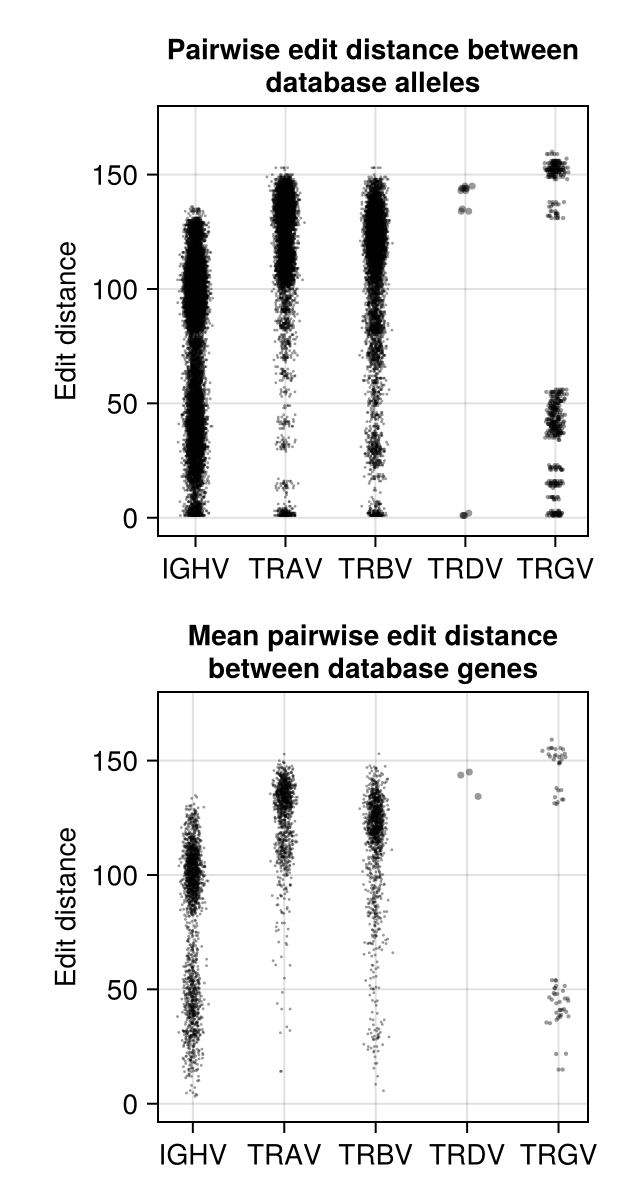

In [4]:
chain2coord = Dict("IGH" => 1.0, "TRA" => 2.0, "TRB" => 3.0, "TRD" => 4.0, "TRG" => 5.0);
chain2markersize = Dict("IGH" => 2, "TRA" => 2.0, "TRB" => 2.0, "TRD" => 5.0, "TRG" => 3.0)
f = CairoMakie.Figure(size = (320, 600))
allele = Axis(f[1,1], title = "Pairwise edit distance between\ndatabase alleles" , ylabel = "Edit distance", xticks = (1:5, ["IGHV", "TRAV", "TRBV", "TRDV", "TRGV"]), aspect = AxisAspect(1.0), limits = (nothing, nothing, -8, 180))
gene = Axis(f[2,1], title = "Mean pairwise edit distance\nbetween database genes", ylabel = "Edit distance", xticks = (1:5, ["IGHV", "TRAV", "TRBV", "TRDV", "TRGV"]), aspect = AxisAspect(1.0), limits = (nothing, nothing, -8, 180))

for chain in ["IGH", "TRA", "TRB", "TRD", "TRG"]
    v = upperright_vec(distmats["edit_$(chain)"].allele_distances)
    CairoMakie.scatter!(allele, add_jitter.(fill(chain2coord[chain], length(v))), v, color = "black", label = chain, markersize = chain2markersize[chain], alpha = 0.4)
end

for chain in ["IGH", "TRA", "TRB", "TRD", "TRG"]
    v = upperright_vec(distmats["edit_$(chain)"].gene_distances)
    CairoMakie.scatter!(gene, add_jitter.(fill(chain2coord[chain], length(v))), v, color = "black", label = chain, markersize = chain2markersize[chain], alpha = 0.4)
end
save(joinpath(out_plot_dir, "database_pairwise_edit_distances.svg"), f)
f

## Get intragene distances

In [5]:
chain = "IGH"
within_gene_dists_dict = Dict()
for chain in ["IGH", "TRA", "TRB", "TRD", "TRG"]
    genes = map(el->split(el, "*")[1], distmats["edit_$(chain)"].alleles)
    unique_genes = unique(genes)
    within_gene_dists = []
    allele_list = []
    for gene in unique_genes
        gene_inds = findall(x->x == gene, genes)
        allele_pair_mat = collect(Iterators.product(distmats["edit_$(chain)"].alleles[gene_inds], distmats["edit_$(chain)"].alleles[gene_inds]))
        curr_within_gene_dists = upperright_vec(distmats["edit_$(chain)"].allele_distances[gene_inds, gene_inds])
        curr_allele_list = upperright_vec(allele_pair_mat)
        # store which alleles I am comparing
        within_gene_dists = vcat(within_gene_dists, curr_within_gene_dists)
        allele_list = vcat(allele_list, curr_allele_list)
    end
    within_gene_dists_dict[chain] = (dists = within_gene_dists, alleles = allele_list)
end

## Plot intragene distances

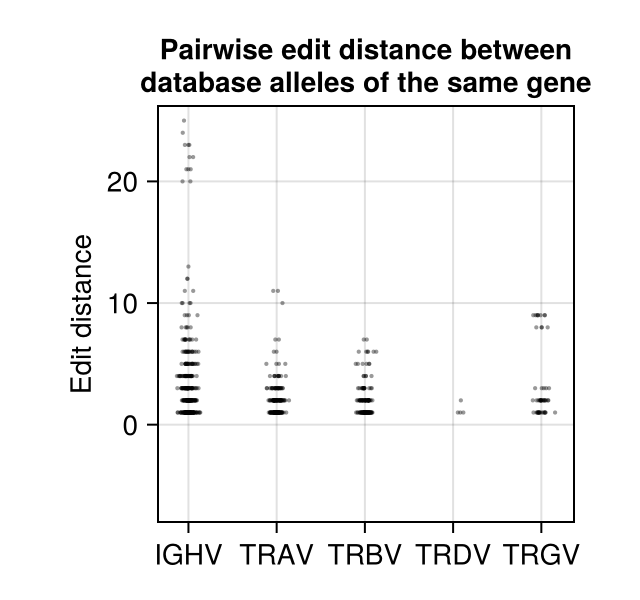

In [6]:
chain2coord = Dict("IGH" => 1.0, "TRA" => 2.0, "TRB" => 3.0, "TRD" => 4.0, "TRG" => 5.0);
chain2markersize = Dict("IGH" => 3, "TRA" => 3, "TRB" => 3, "TRD" => 3, "TRG" => 3)
f = CairoMakie.Figure(size = (320, 300))
allele = Axis(f[1,1], title = "Pairwise edit distance between\ndatabase alleles of the same gene" , ylabel = "Edit distance", xticks = (1:5, ["IGHV", "TRAV", "TRBV", "TRDV", "TRGV"]), aspect = AxisAspect(1.0), limits = (nothing, nothing, -8, nothing))


for chain in ["IGH", "TRA", "TRB", "TRD", "TRG"]
    v = within_gene_dists_dict[chain].dists
    CairoMakie.scatter!(allele, add_jitter.(fill(chain2coord[chain], length(v))), v, color = "black", label = chain, markersize = chain2markersize[chain], alpha = 0.4)
end

save(joinpath(out_plot_dir, "database_within_gene_edit_distances.svg"), f)
f